In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

Importing and processing the USG and ground-based comparison data `csv`, which we use to compute our KDE for speed and radiant uncertainty:

In [2]:
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison/usg-ground-based-comparison_EDITED.csv', sep = ',', skip_blank_lines=True).iloc[2:-3]  
# skip the first two rows after header and the last three rows since those are garbage

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()
# sort dataframe alphabetically
usg_ground_based_comparison.sort_values('Event', inplace=True)

Get the speed and radiant uncertainties:

In [3]:
# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height, Begin Height, End Height, Length to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height', 'Begin Height (km)', 'End Height (km)', 'Length (km)']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# convert date to datetime object
usg_ground_based_comparison['Date'] = pd.to_datetime(usg_ground_based_comparison['Date'])

# usg speed, dv, drad
usg_speed = usg_ground_based_comparison['Speed']
# speed and radiant uncertainties
dv = usg_ground_based_comparison['DV']
drad = usg_ground_based_comparison['Radiant Diff']

Construct the KDEs for speed and log-radiant uncertainty:

Speed uncertainty:

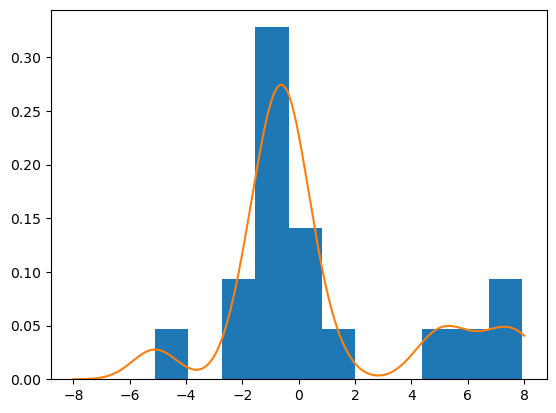

In [4]:
# parameters for fitting the KDE
dv_ub = 8.  # upper bound for fitting kde
dv_lb = -8.  # lower bound for fitting kde
dv_bandwidth = 0.8  # this is finicky
kernel_type = 'gaussian'

# setting up the values
values_dv = np.linspace(dv_lb, dv_ub, int(1e4))
kde_dv = np.array(dv).reshape((len(dv), 1))
kde_values_dv = values_dv.reshape(len(values_dv), 1)

# doing the KDE fit
kde_model_dv = KernelDensity(bandwidth=dv_bandwidth, kernel=kernel_type)
kde_model_dv.fit(kde_dv)

# plotting the KDE
plt.hist(dv, density=True, bins='auto')
plt.plot(kde_values_dv, np.exp(kde_model_dv.score_samples(kde_values_dv)))

Log-radiant uncertainty:

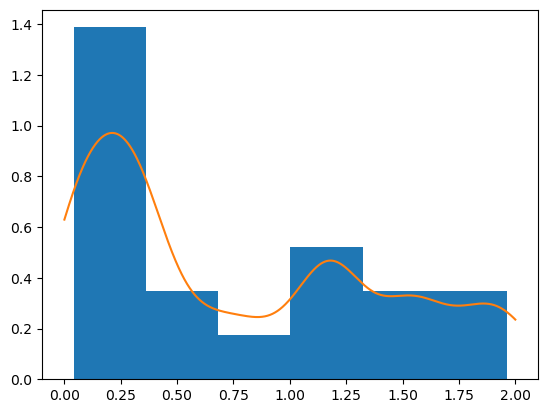

In [5]:
# parameters for the KDE fitting
drad_lb = 0.  # upper bound for fitting kde
drad_ub = 2.  # lower bound for fitting kde
log_drad_bandwidth = 0.15  # this is finicky

# setting up the values
log_drad = np.log10(drad)  # convert to log
values_drad = np.linspace(drad_lb, drad_ub, int(1e4))
kde_log_drad = np.array(log_drad).reshape((len(log_drad), 1))
kde_values_log_drad = values_drad.reshape(len(values_drad), 1)

# kde fit
kde_model_log_drad = KernelDensity(bandwidth=log_drad_bandwidth, kernel=kernel_type)
kde_model_log_drad.fit(kde_log_drad)

# plot
plt.hist(log_drad, density=True, bins='auto')
plt.plot(kde_values_log_drad, np.exp(kde_model_log_drad.score_samples(kde_values_log_drad)))

Reading in the `.dat` file for the Granvik model, the directory `granvik-model` should be in the same directory as this notebook -- **get the model from the dropbox if you want to use locally!**

In [6]:
# defining the granvik columns (could figure out how to get pandas to read this automatically in the dat file that actually has headers
granvik_columns = ['sma', 'ecc', 'inc', 'Hmag', 'number', 'rel_dnumber', 
                   'nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                   'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma', '3/1_prob', 'PHO_sigma', 'JFC_sigma', 
                   'pv<0.1', '0.1<pv<0.3', 'sig', 'albedo_cat', 'collprob', 'MOID']

# read in the granvik file
granvik_model = pd.read_csv('granvik-model/gmb_model-noheader.dat', delim_whitespace=True, skip_blank_lines=True, header=None, float_precision='high')
granvik_model.columns = granvik_columns  # columns

Reading in the `.csv` file containing the decameter impactors:

In [7]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1).csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]
# convert time to datetime format
decameter_impactors['Time'] = pd.to_datetime(decameter_impactors['Time'])
# convert every column other than time to numeric
decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']] = decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']].apply(pd.to_numeric, errors='coerce', axis=1)

/tmp/ipykernel_2674626/2348476191.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decameter_impactors['Time'] = pd.to_datetime(decameter_impactors['Time'])
/tmp/ipykernel_2674626/2348476191.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']] = decameter_impactors[decameter_impactors.columns[decameter_impactors.columns != 'Time']].apply(pd.to_numeric, errors='coerce', axis=1)


Now we want to convert the state vectors for the $100$ Monte Carlo samples of each decameter impact event. We first take $100$ Monte Carlo samples using the KDEs defined earlier. The state vectors we use are:
- Velocity
- Time of observation
- Latitude
- Longitude
- Elevation
- Azimuth
- Altitude
  
with random velocity errors added that we draw from our KDE for the velocity uncertainty earlier. The state vectors are then converted 
into orbital elements $\left(a, e, i, \Omega, \omega, M\right)$ (semi-major axis, eccentricity, inclination, longitude of ascending node, argument of pericenter, mean anomaly)  using `WMPL`.


**TODO**: figure out how to implement the `drad` uncertainty (since the radiant uncertainty is dependent on both the altitude and the azimuth, so see how `drad` breaks down into individual uncertainties for altitude and azimuth):

First get the state vectors for all the events:

In [8]:
# state vectors
state_vector_list = ['Speed', 'Time', 'Latitude Numerical', 'Longitude Numerical', 'Altitude(km)', 'Zenith Distance', 'Radiant azimuth']
# drops the 1994 event right now as it doesn't have a lot of the information, and reset the index
impactor_state_vectors = decameter_impactors[state_vector_list].dropna().reset_index(drop=True)
# convert time to the format that wmpl takes in, '%Y%m%d-%H%M%S.%f'
impactor_state_vectors['Time'] = impactor_state_vectors['Time'].dt.strftime('%Y%m%d-%H%M%S.%f')

Then for each event, get $100$ Monte Carlo samples, compute the orbital parameters for each Monte Carlo samples, and save it to an array:

Defining the `get_orbital_parameters` function to be used for computing orbital parameters from the state vector parameters -- this should be run in the `wmpl` conda environment or any environment with the `wmpl.Trajectory.Orbit` module active:

In [9]:
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

def get_orbital_parameters(state_vector_params, orb_param_variables=orb_param_variables):
    """
    Gets the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector

    param state_vector_params: tuple of (dv, v, t, a, o, e, azim, alt):
    dv is the velocity uncertainty to be added to the velocity vector
    v is the velocity
    t is the time of the event
    a is the latitude
    o is the longitude
    e is the elevation of the event
    azim is the radiant azimuth
    zen is the zenith distance (90 minus the altitude angle)

    returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
    """
    dv, v, t, a, o, e, azim, zen = state_vector_params  # get the state vector parameters
    # converting from zenith angle to altitude angle
    alt = 90 - zen
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in velocity to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array = [np.float64(string) for param in orb_param_list 
    #                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan']]
    
    orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                                 list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                                 if elem.startswith(tuple(orb_param_variables))] 
                                for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    
    #### ADD THIS AS A SAFEGUARD BECAUSE IT SEEMS LIKE SOMETIMES WMPL DOESN'T RETURN THE ORBITAL ELEMENTS AT ALL

    # if empty, return an array with the right size with all nans...
    # this is the safeguard for now
    if not orb_param_array.size:
        orb_param_array = np.repeat(np.nan, len(orb_param_variables))
    
    # return the orbital parameter array
    return orb_param_array

Optional: Computing orbital parameters from state vector parameters using multiprocessing -- skip this cell if already have the orbital parameters saved as a `.npy` or something

In [10]:
# from tqdm import tqdm
# import multiprocessing

# # number of Monte Carlo samples for each event
# n_monte_carlo_samples = 100

# # initialize array for orbital parameters for all the events with the shape 
# # (number of impact events, number of monte carlo samples per event, number of orbital parameters per monte carlo sample)
# orb_param_array_all_events = np.zeros((len(impactor_state_vectors), n_monte_carlo_samples, len(orb_param_variables)))

# # compute orbital parameters of Monte Carlo samples for each event in the decameter impactors table
# for i, event in impactor_state_vectors.iterrows():
#     # perform the Monte Carlo sampling and flatten the array
#     dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()
    
#     # get the state vectors to input into the wmpl.Trajectory.Orbit file
#     v = event['Speed']
#     t = event['Time']
#     a = event['Latitude Numerical']
#     o = event['Longitude Numerical']
#     e = event['Altitude(km)']
#     azim = event['Radiant azimuth']
#     # zenith distance, note that altitude is 90 minus the zenith distance! 
#     zen = event['Zenith Distance']  # this is converted to alt in the get_orbital_parameters function

#     # create parameter list for multiprocessing
#     state_vector_par_list = []
#     # use different dv for each set of parameters
#     for dv in dv_samples:
#         state_vector_params = (dv, v, t, a, o, e, azim, zen)
#         state_vector_par_list.append(state_vector_params)
    
#     # now compute the orbital parameters from the state vectors for each Monte Carlo sample, using multiprocessing:
#     pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
#     # get the array of orbital parameters for all the monte carlo samples of this single event, using multiprocessing
#     orb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list))))
#     # add the orb param array for this single event to the orbital parameter array for all events
#     orb_param_array_all_events[i] = orb_param_array_single_event

Optional: Save the file as a numpy array (although it doesn't take too long to run, something like ~7 minutes to run with multiprocessing on my office workstation)

In [11]:
# np.save('orb_params_all_events_mc.npy', orb_param_array_all_events)  # save as a .npy file

Optional: Read in `.npy` file for all the orbital parameters if haven't already run the multiprocessing code:

In [12]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters

Plotting distribution of semi-major axis for these events vs. the "true" value as a test to see if the pipeline is working as we expect:

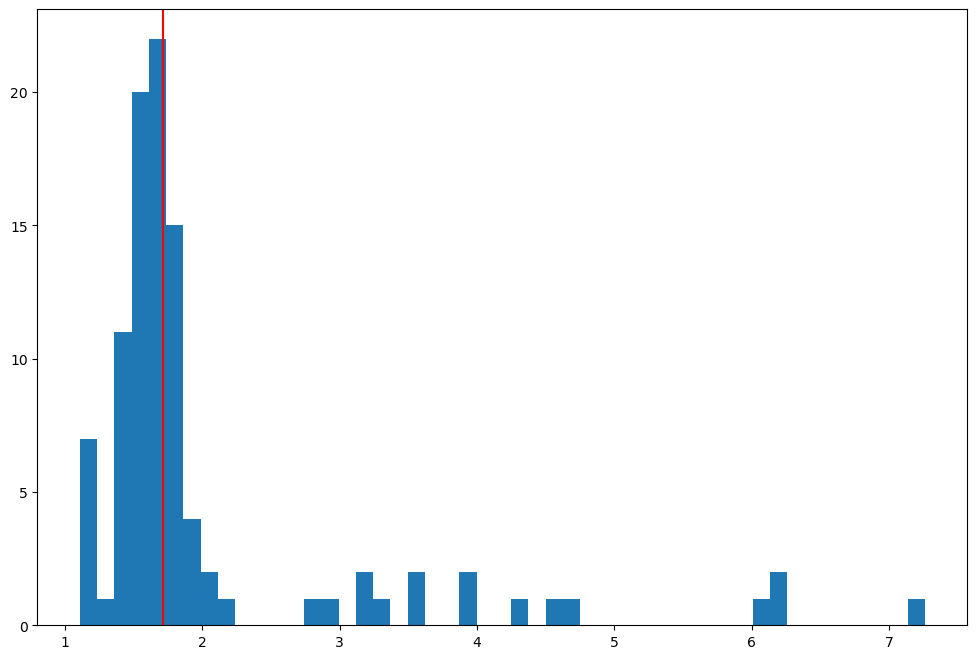

(1.7126588, 1.637314)

In [13]:
# get "true" semi-major axes from the sheet
true_smas = decameter_impactors['a'].dropna().reset_index(drop=True)
# get mc'ed semi-major axes
event_ind = 0  # event to check

# filter outliers to make the histogram a bit easier to see
filtered_array = orb_param_array_all_events[event_ind, :, 0][(orb_param_array_all_events[event_ind, :, 0] 
                                                              < 20) & (orb_param_array_all_events[event_ind, :, 0] 
                                                                       > -20)]

# plot everything
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compared to the "true" value
plt.hist(filtered_array, bins='auto')  # plot histogram
# plot true value
plt.axvline(true_smas[event_ind], c='r')
plt.show()
true_smas[event_ind], np.median(filtered_array)

Now get the $a$, $e$, $i$ values for all the events:

In [119]:
# getting the indices for a, e and i in the orbital parameters array (should be the same order as in orb_param_variables)
a_index = orb_param_variables.index('a')
e_index = orb_param_variables.index('e')
i_index = orb_param_variables.index('i')

# these will have the shape (number of events, number of Monte Carlo simulations, 3)
mc_aeis = orb_param_array_all_events[:, :, [a_index, e_index, i_index]]

Add $H$ to the $a$, $e$, $i$s as well:

In [120]:
H = 20. # placeholder until I figure out what H actually should be...
mc_aeihs = np.concatenate((mc_aeis, np.ones((mc_aeis.shape[0], mc_aeis.shape[1], 1)) * H), axis=2)

Interpolate the Granvik file for intermediate values of the parameter space:

Try nearest-neighbours, `LinearND`, `RBF` and my own `lerp` implementation interpolations:

Try using basic nearest-neighbours interpolation first, as `LinearND` does not work:

In [142]:
mc_aeihs[4][11]

array([nan, nan, nan, 20.])

In [143]:
testinterp = scipy.interpolate.NearestNDInterpolator(granvik_aeihs, np.array(granvik_model['nu6_prob']), 
                                                     rescale=True)(mc_aeihs[4][11])
testinterp

IndexError: index 773280 is out of bounds for axis 0 with size 773280

Get the escape region probabilities and the $a$, $e$, $i$, $H$ values from the Granvik model:

In [122]:
# escape region probabilities
er_prob_params = ['nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob']
er_probs = granvik_model[er_prob_params]

# a, e, i, H values
granvik_aeihs = granvik_model[['sma', 'ecc', 'inc', 'Hmag']]

In [130]:
for column in er_probs.columns:
    for event_samples in mc_aeihs:
        # event_samples is (100, 4) array of all the MC samples for a given even
        print(event_samples)
        interp_probs = scipy.interpolate.NearestNDInterpolator(granvik_aeihs, np.array(er_probs[column]), 
                                                     rescale=True)(event_samples)

[[ 6.215276  0.892425  9.738173 20.      ]
 [ 2.002317  0.636153  5.553677 20.      ]
 [ 4.685076  0.855745  9.193961 20.      ]
 [ 1.835755  0.596849  4.826168 20.      ]
 [ 1.384989  0.420342  1.313088 20.      ]
 [ 1.569132  0.510264  3.143423 20.      ]
 [ 3.572121  0.807997  8.460084 20.      ]
 [ 1.728525  0.566334  4.245142 20.      ]
 [ 2.034399  0.642816  5.67465  20.      ]
 [ 1.631576  0.534049  3.615813 20.      ]
 [ 1.608693  0.525637  3.449541 20.      ]
 [ 3.570027  0.807877  8.458203 20.      ]
 [ 1.608329  0.525501  3.446834 20.      ]
 [ 1.18221   0.257268  1.721738 20.      ]
 [ 1.798454  0.586771  4.635805 20.      ]
 [ 1.921936  0.618248  5.225206 20.      ]
 [ 1.57929   0.514317  3.224403 20.      ]
 [ 1.715063  0.562145  4.164316 20.      ]
 [ 1.596858  0.521152  3.36053  20.      ]
 [ 1.54793   0.501554  2.968779 20.      ]
 [ 3.947757  0.827313  8.760548 20.      ]
 [ 1.656557  0.542864  3.789067 20.      ]
 [ 1.523081  0.490888  2.753815 20.      ]
 [ 1.789163

IndexError: index 773280 is out of bounds for axis 0 with size 773280

In [ ]:
for 
for i, event in enumerate(aeihs):

In [100]:
for i, event in enumerate(aeihs):
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
    
rb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list))))

(100, 4)


In [102]:
aeihs[0]

array([[ 6.215276,  0.892425,  9.738173, 20.      ],
       [ 2.002317,  0.636153,  5.553677, 20.      ],
       [ 4.685076,  0.855745,  9.193961, 20.      ],
       [ 1.835755,  0.596849,  4.826168, 20.      ],
       [ 1.384989,  0.420342,  1.313088, 20.      ],
       [ 1.569132,  0.510264,  3.143423, 20.      ],
       [ 3.572121,  0.807997,  8.460084, 20.      ],
       [ 1.728525,  0.566334,  4.245142, 20.      ],
       [ 2.034399,  0.642816,  5.67465 , 20.      ],
       [ 1.631576,  0.534049,  3.615813, 20.      ],
       [ 1.608693,  0.525637,  3.449541, 20.      ],
       [ 3.570027,  0.807877,  8.458203, 20.      ],
       [ 1.608329,  0.525501,  3.446834, 20.      ],
       [ 1.18221 ,  0.257268,  1.721738, 20.      ],
       [ 1.798454,  0.586771,  4.635805, 20.      ],
       [ 1.921936,  0.618248,  5.225206, 20.      ],
       [ 1.57929 ,  0.514317,  3.224403, 20.      ],
       [ 1.715063,  0.562145,  4.164316, 20.      ],
       [ 1.596858,  0.521152,  3.36053 , 20.  

In [ ]:
for i, event in impactor_state_vectors.iterrows():
    # perform the Monte Carlo sampling and flatten the array
    dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()
    
    # get the state vectors to input into the wmpl.Trajectory.Orbit file
    v = event['Speed']
    t = event['Time']
    a = event['Latitude Numerical']
    o = event['Longitude Numerical']
    e = event['Altitude(km)']
    azim = event['Radiant azimuth']
    # zenith distance, note that altitude is 90 minus the zenith distance! 
    zen = event['Zenith Distance']  # this is converted to alt in the get_orbital_parameters function

    # create parameter list for multiprocessing
    state_vector_par_list = []
    # use different dv for each set of parameters
    for dv in dv_samples:
        state_vector_params = (dv, v, t, a, o, e, azim, zen)
        state_vector_par_list.append(state_vector_params)
    
    # now compute the orbital parameters from the state vectors for each Monte Carlo sample, using multiprocessing:
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
    # get the array of orbital parameters for all the monte carlo samples of this single event, using multiprocessing
    orb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list))))
    # add the orb param array for this single event to the orbital parameter array for all events
    orb_param_array_all_events[i] = orb_param_array_single_event

In [ ]:
testinterp = scipy.interpolate.NearestNDInterpolator(xtest, np.array(granvik_model['nu6_prob']), 
                                                     rescale=True)(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

Stepsize in:

- SMA: 0.1
- Ecc: 0.04
- Inc: 4
- H: 0.25
  

In [15]:
smas = granvik_model['sma']
eccs = granvik_model['ecc']
incs = granvik_model['inc']
Hs = granvik_model['Hmag']

In [16]:
def lerp_4d():
    """
    Basic 4d lerp function only taking into account the adjacent two points
    """
    

In [17]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_sma_ind = np.where(smas == smas[smas >= 2.002317].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_sma_ind = np.where(smas == smas[smas <= 2.002317].max())

In [18]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_ecc_ind = np.where(eccs == eccs[eccs >= 0.636153].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_ecc_ind = np.where(eccs == eccs[eccs <= 0.636153].max())

In [19]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_inc_ind = np.where(incs == incs[incs >= 5.553677].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_inc_ind = np.where(incs == incs[incs <= 5.553677].max())

In [20]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_H_ind = np.where(Hs == Hs[Hs >= 20.].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_H_ind = np.where(Hs == Hs[Hs <= 20.].max())

In [21]:
from functools import reduce

common_index_ub = reduce(np.intersect1d, (interp_ub_sma_ind, interp_ub_ecc_ind, interp_ub_inc_ind, interp_ub_H_ind))
common_index_lb = reduce(np.intersect1d, (interp_lb_sma_ind, interp_lb_ecc_ind, interp_lb_inc_ind, interp_lb_H_ind))

In [22]:
granvik_model.iloc[common_index_ub]

,sma,ecc,inc,Hmag,number,rel_dnumber,nu6_prob,5/2_prob,2/1_prob,HUN_prob,...,HUN_sigma,3/1_prob,PHO_sigma,JFC_sigma,pv<0.1,0.1<pv<0.3,sig,albedo_cat,collprob,MOID
350740,2.05,0.66,6.0,20.125,0.8792,0.024659,0.88687,0.0201,0.0002,0.00976,...,0.00162,0.00925,0.0001,0.0001,0.12504,0.57157,0.01645,0.00596,4.867000e-17,18.13


In [23]:
granvik_model.iloc[common_index_lb]

,sma,ecc,inc,Hmag,number,rel_dnumber,nu6_prob,5/2_prob,2/1_prob,HUN_prob,...,HUN_sigma,3/1_prob,PHO_sigma,JFC_sigma,pv<0.1,0.1<pv<0.3,sig,albedo_cat,collprob,MOID
326739,1.95,0.62,2.0,19.875,0.2249,0.021258,0.89193,0.00626,0.0,0.01052,...,0.00164,0.01019,0.00009,0.00002,0.12247,0.57337,0.01615,0.00628,2.342000e-16,16.19


In [56]:
granvik_model.loc[granvik_model['nu6_prob'] == testinterp[0]]

,sma,ecc,inc,Hmag,number,rel_dnumber,nu6_prob,5/2_prob,2/1_prob,HUN_prob,...,HUN_sigma,3/1_prob,PHO_sigma,JFC_sigma,pv<0.1,0.1<pv<0.3,sig,albedo_cat,collprob,MOID
102492,0.85,0.62,66.0,18.125,0.007715,0.037654,0.90423,0.07038,0.00000,0.02245,...,0.00251,0.00000,0.00048,0.00000,0.13129,0.54734,0.01650,0.00310,3.210000e-17,32.98
194698,1.25,0.86,42.0,19.625,0.032100,0.072991,0.90423,0.00168,0.00000,0.05667,...,0.00812,0.00171,0.00606,0.00000,0.12407,0.53317,0.01417,0.00416,2.137000e-17,34.62
349380,2.05,0.62,6.0,20.125,1.045000,0.022325,0.90423,0.01307,0.00003,0.01030,...,0.00171,0.00816,0.00009,0.00003,0.12326,0.56919,0.01604,0.00563,6.151000e-17,15.63


In [55]:
testinterp = scipy.interpolate.NearestNDInterpolator(xtest, np.array(granvik_model['nu6_prob']), rescale=True)(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton

rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)

In [25]:
# scipy.interpolate.LinearNDInterpolator(xtest, np.array(granvik_model['nu6_prob']))

In [26]:
scipy.interpolate.RBFInterpolator(xtest, np.array(granvik_model['nu6_prob']), neighbors=1e4, kernel='linear')(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

NameError: name 'xtest' is not defined

In [27]:
xtest = np.array(granvik_model[['sma', 'ecc', 'inc', 'Hmag']])
smas, eccs, incs, Hs = tuple(xtest.T)
smas, eccs, incs, Hs

(array([0.35, 0.35, 0.35, ..., 4.15, 4.15, 4.15]),
 array([0.02, 0.02, 0.02, ..., 0.98, 0.98, 0.98]),
 array([  2.,   2.,   2., ..., 178., 178., 178.]),
 array([15.125, 15.375, 15.625, ..., 24.375, 24.625, 24.875]))

In [28]:
len(smas[smas == 0.35])

6400

In [29]:
eps = 1e-12
np.arange(0., len(smas[smas == 0.35])*eps, eps)

array([0.000e+00, 1.000e-12, 2.000e-12, ..., 6.397e-09, 6.398e-09,
       6.399e-09])

In [30]:
def add_epsilon(arr, eps=1e-12):
    """
    Helper function to add epsilons to an array with many repeating values to make them all unique, so that array can be used
    in interpolation
    """
    new_arr = []

    for elem in np.unique(arr):
        # print(elem)
        new_arr.append(list(np.add(arr[arr == elem], np.linspace(0., len(arr[arr == elem]) * eps, len(arr[arr == elem])))))

    return np.array([item for ls in new_arr for item in ls])

In [31]:
new_smas = add_epsilon(smas)
new_eccs = add_epsilon(eccs)
new_incs = add_epsilon(incs)
new_Hs = add_epsilon(Hs)

In [32]:
xtest_old = np.array(granvik_model[['sma', 'ecc', 'inc', 'Hmag']])
xtest_new = np.array((new_smas, new_eccs, new_incs, new_Hs)).T

In [33]:
scipy.interpolate.RBFInterpolator(xtest_new, np.array(granvik_model['nu6_prob']), neighbors=1e4, kernel='linear')(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

array([0.79174805])

In [ ]:
scipy.interpolate.RegularGridInterpolator((new_smas, new_eccs, new_incs, new_Hs), np.array(granvik_model['nu6_prob']))

In [37]:
len(np.unique(smas)), len(np.unique(eccs)), len(np.unique(incs)), len(np.unique(Hs))

(39, 25, 45, 41)

In [40]:
np.min(smas), np.max(smas)

(0.35, 4.15)

In [44]:
np.arange(np.min(smas), np.max(smas) + 0.1, 0.1)

array([0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35,
       1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15])

In [39]:
len(granvik_model['nu6_prob'])

773280

In [153]:
scipy.interpolate.griddata(xtest_new, np.array(granvik_model['nu6_prob']), np.array([[2.002317, 0.636153, 5.553677, 20.]]), method='linear')

QhullError: QH6271 qhull topology error (qh_check_dupridge): wide merge (3841243076.5x wider) due to dupridge between f1893 and f1882 (vertex dist 8.5e-11), merge dist 0.037, while processing p768440
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6271 qhull topology error (qh_check_dupridge): wide merge (3171684891.3x wider) due to dupridge between f2232 and f2246 (vertex dist 2e-11), merge dist 0.031, while processing p464117
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6271 qhull topology error (qh_check_dupridge): wide merge (4110990730.4x wider) due to dupridge between f2988 and f2982 (vertex dist 2e-11), merge dist 0.04, while processing p45680
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6271 qhull topology error (qh_check_dupridge): wide merge (1350988278.4x wider) due to dupridge between f3004 and f2955 (vertex dist 4.4e-11), merge dist 0.013, while processing p45680
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6271 qhull topology error (qh_check_dupridge): wide merge (1431371419.7x wider) due to dupridge between f3110 and f3133 (vertex dist 4.4e-11), merge dist 0.014, while processing p26973
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6418 qhull precision error (qh_merge_twisted): twisted facet f3231 with pinched vertices.  Could merge vertices, but too wide to merge into neighbor.   mindist -9.9e-05 maxdist  0 vertexdist 3.9e-10 neighbor f3482 mindist -4e-07 maxdist  0
ERRONEOUS FACET:
- f3231
    - flags: bottom tested
    - merges: 3
    - normal:  0.004975 0.001393   0.0396   0.1546  -0.9872
    - offset:  -2.419719
    - center: 0.5166666720567763 0.1000000064038439 4.666666674030143 15.33333334234693 0.1404651730266181 
    - vertices: p6596(v67) p45680(v64) p38663(v63) p26640(v21) p26760(v16) p6400(v6)
    - neighboring facets: f2954 f2936 f3482 f3226 f3228 f3230 f3229 f2866
    - ridges:
     - r2554 tested simplicialtop simplicialbot
           vertices: p45680(v64) p38663(v63) p26640(v21) p26760(v16)
           between f2954 and f3231
     - r2992 tested simplicialbot
           vertices: p45680(v64) p26640(v21) p26760(v16) p6400(v6)
           between f3231 and f2936
     - r2556 nonconvex simplicialtop
           vertices: p45680(v64) p38663(v63) p26760(v16) p6400(v6)
           between f3482 and f3231
     - r2984 tested
           vertices: p6596(v67) p45680(v64) p38663(v63) p6400(v6)
           between f3231 and f3226
     - r2988 tested simplicialtop simplicialbot
           vertices: p6596(v67) p45680(v64) p38663(v63) p26640(v21)
           between f3228 and f3231
     - r2993 tested simplicialtop
           vertices: p6596(v67) p45680(v64) p26640(v21) p6400(v6)
           between f3230 and f3231
     - r2991 tested simplicialbot
           vertices: p6596(v67) p38663(v63) p26640(v21) p6400(v6)
           between f3231 and f3229
     - r2989 tested simplicialtop
           vertices: p38663(v63) p26640(v21) p26760(v16) p6400(v6)
           between f2866 and f3231
ERRONEOUS OTHER FACET:
- f3482
    - flags: top newfacet newmerge
    - merges: 21
    - normal:    0.9285 -8.289e-08 2.591e-10  -0.3714 -3.123e-09
    - offset:   5.199469
    - maxoutside: 2.227882e-09
    - vertices: p132920(v70) p26973(v66) p45680(v64) p38663(v63) p77327(v58) p49679(v42) p26782(v41) p26760(v16) p135323(v9) p6400(v6)
    - neighboring facets: f3231 f3512 f3485 f3226 f3446 f3144 f2859 f2998 f3433 f3445 f2954 f3489 f3208 f3524 f3491 f3490 f3479 f3204 f3521 f3506 f3108
    - ridges:
     - r2556 nonconvex simplicialtop
           vertices: p45680(v64) p38663(v63) p26760(v16) p6400(v6)
           between f3482 and f3231
     - r3279 simplicialtop
           vertices: p132920(v70) p26973(v66) p26782(v41) p6400(v6)
           between f3512 and f3482
     - r3276
           vertices: p132920(v70) p26782(v41) p26760(v16) p6400(v6)
           between f3512 and f3482
     - r3352 simplicialtop simplicialbot
           vertices: p132920(v70) p45680(v64) p26760(v16) p6400(v6)
           between f3482 and f3485
     - r2559 nonconvex
           vertices: p45680(v64) p38663(v63) p49679(v42) p6400(v6)
           between f3226 and f3482
     - r3209 simplicialtop
           vertices: p132920(v70) p38663(v63) p77327(v58) p26760(v16)
           between f3446 and f3482
     - r2756
           vertices: p26973(v66) p77327(v58) p26782(v41) p26760(v16)
           between f3144 and f3482
     - r2751
           vertices: p26973(v66) p38663(v63) p49679(v42) p26782(v41)
           between f3144 and f3482
     - r2749
           vertices: p26973(v66) p49679(v42) p26782(v41) p26760(v16)
           between f3482 and f3144
     - r2891 simplicialtop
           vertices: p26973(v66) p38663(v63) p77327(v58) p49679(v42)
           between f3144 and f3482
     - r2484
           vertices: p38663(v63) p77327(v58) p26782(v41) p26760(v16)
           between f3482 and f3144
     - r2759
           vertices: p26973(v66) p38663(v63) p77327(v58) p26782(v41)
           between f3482 and f3144
     - r2755
           vertices: p26973(v66) p38663(v63) p26782(v41) p26760(v16)
           between f3482 and f2859
     - r2805
           vertices: p26973(v66) p38663(v63) p26782(v41) p6400(v6)
           between f2859 and f3482
     - r2467
           vertices: p38663(v63) p26782(v41) p26760(v16) p6400(v6)
           between f3482 and f2859
     - r2818
           vertices: p26973(v66) p77327(v58) p49679(v42) p26760(v16)
           between f3482 and f2998
     - r2549 simplicialtop
           vertices: p45680(v64) p77327(v58) p49679(v42) p26760(v16)
           between f2998 and f3482
     - r3219 simplicialtop
           vertices: p132920(v70) p38663(v63) p26760(v16) p135323(v9)
           between f3433 and f3482
     - r3267 simplicialbot
           vertices: p132920(v70) p38663(v63) p77327(v58) p135323(v9)
           between f3482 and f3445
     - r2548
           vertices: p45680(v64) p49679(v42) p26782(v41) p26760(v16)
           between f2954 and f3482
     - r2552
           vertices: p45680(v64) p38663(v63) p49679(v42) p26782(v41)
           between f3482 and f2954
     - r2550
           vertices: p45680(v64) p38663(v63) p26782(v41) p26760(v16)
           between f3482 and f2954
     - r3264 nonconvex simplicialbot
           vertices: p132920(v70) p45680(v64) p77327(v58) p26760(v16)
           between f3482 and f3489
     - r3041 nonconvex simplicialtop
           vertices: p38663(v63) p77327(v58) p49679(v42) p135323(v9)
           between f3208 and f3482
     - r2916 nonconvex
           vertices: p38663(v63) p49679(v42) p135323(v9) p6400(v6)
           between f3482 and f3208
     - r3224 nonconvex
           vertices: p132920(v70) p26973(v66) p26782(v41) p26760(v16)
           between f3482 and f3524
     - r3265 nonconvex simplicialtop
           vertices: p132920(v70) p45680(v64) p77327(v58) p49679(v42)
           between f3491 and f3482
     - r3255 nonconvex simplicialbot
           vertices: p132920(v70) p77327(v58) p49679(v42) p135323(v9)
           between f3482 and f3490
     - r3350
           vertices: p132920(v70) p45680(v64) p49679(v42) p6400(v6)
           between f3479 and f3482
     - r3300 simplicialtop
           vertices: p132920(v70) p49679(v42) p135323(v9) p6400(v6)
           between f3479 and f3482
     - r2917
           vertices: p26973(v66) p38663(v63) p135323(v9) p6400(v6)
           between f3482 and f3204
     - r3214 nonconvex
           vertices: p132920(v70) p26973(v66) p135323(v9) p6400(v6)
           between f3482 and f3521
     - r3220 nonconvex
           vertices: p132920(v70) p26973(v66) p26760(v16) p135323(v9)
           between f3482 and f3506
     - r2753
           vertices: p26973(v66) p38663(v63) p26760(v16) p135323(v9)
           between f3482 and f3108

While executing:  | qhull d Qc Qbb Q12 Qt Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1919688304  delaunay  Qcoplanar-keep  Qbbound-last  Q12-allow-wide
  Qtriangulate  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 1.8e+02  Error-roundoff 4.7e-13  _one-merge 5.2e-12
  Visible-distance 2.8e-12  U-max-coplanar 2.8e-12  Width-outside 5.7e-12
  _wide-facet 1.7e-11  _maxoutside 0.018
Last point added to hull was p132920.  Last merge was #856.

At error exit:

Delaunay triangulation by the convex hull of 773281 points in 5-d:

  Number of input sites and at-infinity: 68
  Total number of deleted points due to merging: 2
  Number of nearly incident points: 32419
  Number of Delaunay regions: 530
  Number of non-simplicial Delaunay regions: 125

Statistics for:  | qhull d Qc Qbb Q12 Qt Qz

  Number of points processed: 70
  Number of hyperplanes created: 3156
  Number of facets in hull: 732
  Number of distance tests for qhull: 60537535
  Number of distance tests for merging: 45896
  Number of distance tests for checking: 0
  Number of merged facets: 878
  Maximum distance of point above facet: 0.018 (3221282489.0x)
  Maximum distance of vertex below facet: -0.06 (10574595634.9x)


precision problems (corrected unless 'Q0' or an error)
      5 flipped facets
    300 coplanar horizon facets for new vertices
  32425 coplanar points during partitioning
    121 nearly singular or axis-parallel hyperplanes
      7 dupridges with multiple neighbors

A wide merge error has occurred.  Qhull has produced a wide facet due to facet merges and vertex merges.
This usually occurs when the input is nearly degenerate and substantial merging has occurred.
See http://www.qhull.org/html/qh-impre.htm#limit


In [156]:
scipy.interpolate.LinearNDInterpolator(xtest_new, np.array(granvik_model['nu6_prob']))(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

QhullError: QH6271 qhull topology error (qh_check_dupridge): wide merge (321812809422.9x wider) due to dupridge between f6495 and f6494 (vertex dist 1.4e-12), merge dist 0.0076, while processing p10803
- Allow error with option 'Q12'
- Experimental option merge-pinched-vertices ('Q14') may avoid this error.  It merges nearly adjacent vertices.
- A bounding box for the input sites may alleviate this error.
QH6417 qhull precision error (qh_merge_twisted): twisted facet f12329 does not contain pinched vertices.  Too wide to merge into neighbor.  mindist -1.5e-05 maxdist  0 vertexdist 1.1e-12 maxpinched 4e-13 neighbor f12302 mindist -0.017 maxdist  0
ERRONEOUS FACET:
- f12329
    - flags: bottom newfacet tested newmerge
    - merges: 8
    - normal:    0.6535  -0.1508  -0.7402  0.01226 -0.04668
    - offset: -0.03502885
    - center: 0.03277834713526555 0.01961128104485934 -0.02691192647777188 0.03205128427340493 0.08029678948591182 
    - vertices: p390959(v186) p386642(v149) p558080(v128) p386641(v103) p538480(v52) p386640(v27) p49679(v24) p560628(v8)
    - neighboring facets: f7599 f12313 f12320 f12337 f12314 f7568 f12332 f12274 f12302 f7583
    - ridges:
     - r4040 tested simplicialtop simplicialbot
           vertices: p558080(v128) p538480(v52) p49679(v24) p560628(v8)
           between f7599 and f12329
     - r4041 tested simplicialtop simplicialbot
           vertices: p390959(v186) p538480(v52) p49679(v24) p560628(v8)
           between f12329 and f12313
     - r3805 tested
           vertices: p390959(v186) p386641(v103) p386640(v27) p49679(v24)
           between f12329 and f12320
     - r3927 tested
           vertices: p390959(v186) p386642(v149) p386641(v103) p49679(v24)
           between f12329 and f12320
     - r3841 tested simplicialtop
           vertices: p390959(v186) p538480(v52) p386640(v27) p560628(v8)
           between f12337 and f12329
     - r3825 tested simplicialtop
           vertices: p390959(v186) p386640(v27) p49679(v24) p560628(v8)
           between f12314 and f12329
     - r3839 tested simplicialbot
           vertices: p558080(v128) p538480(v52) p386640(v27) p560628(v8)
           between f12329 and f7568
     - r3810 tested
           vertices: p390959(v186) p386642(v149) p538480(v52) p386640(v27)
           between f12329 and f12332
     - r3918 tested
           vertices: p390959(v186) p386642(v149) p386641(v103) p538480(v52)
           between f12329 and f12332
     - r3811 tested
           vertices: p390959(v186) p386642(v149) p386641(v103) p386640(v27)
           between f12332 and f12329
     - r3932
           vertices: p390959(v186) p558080(v128) p386641(v103) p538480(v52)
           between f12274 and f12329
     - r4042 simplicialbot
           vertices: p390959(v186) p558080(v128) p538480(v52) p49679(v24)
           between f12274 and f12329
     - r2236
           vertices: p386642(v149) p558080(v128) p538480(v52) p386640(v27)
           between f12329 and f12274
     - r2208
           vertices: p386642(v149) p558080(v128) p386641(v103) p538480(v52)
           between f12329 and f12274
     - r2197
           vertices: p386642(v149) p558080(v128) p386640(v27) p49679(v24)
           between f12329 and f12274
     - r3834
           vertices: p390959(v186) p386642(v149) p558080(v128) p49679(v24)
           between f12274 and f12329
     - r2171
           vertices: p386642(v149) p386641(v103) p386640(v27) p49679(v24)
           between f12274 and f12329
     - r3789 tested nonconvex simplicialbot
           vertices: p390959(v186) p386642(v149) p558080(v128) p386641(v103)
           between f12329 and f12302
     - r3829 tested simplicialbot
           vertices: p558080(v128) p386640(v27) p49679(v24) p560628(v8)
           between f12329 and f7583
ERRONEOUS OTHER FACET:
- f12302
    - flags: bottom newfacet tested keepcentrum mergeridge1 newmerge
    - merges: 1
    - normal:   0.08563  0.02388   0.3138 2.853e-09  -0.9453
    - offset: 0.01375108
    - center: 0.04049741296117436 0.06129011306229903 -0.02012325454433898 0.03418803680534143 0.01308326404936428 
    - vertices: p390959(v186) p386642(v149) p558080(v128) p367307(v109) p386641(v103) p386639(v70)
    - neighboring facets: f12274 f12253 f12329 f9337 f12283 f6134
    - ridges:
     - r2196 simplicialbot
           vertices: p386642(v149) p558080(v128) p386641(v103) p386639(v70)
           between f12274 and f12302
     - r3787 nonconvex simplicialtop
           vertices: p390959(v186) p558080(v128) p386641(v103) p386639(v70)
           between f12302 and f12274
     - r3788 simplicialtop
           vertices: p390959(v186) p386642(v149) p558080(v128) p386639(v70)
           between f12302 and f12274
     - r3803 tested simplicialtop
           vertices: p390959(v186) p386642(v149) p367307(v109) p386639(v70)
           between f12253 and f12302
     - r3789 tested nonconvex simplicialbot
           vertices: p390959(v186) p386642(v149) p558080(v128) p386641(v103)
           between f12329 and f12302
     - r3804 tested simplicialbot
           vertices: p390959(v186) p386642(v149) p367307(v109) p386641(v103)
           between f12302 and f9337
     - r3801 nonconvex
           vertices: p390959(v186) p367307(v109) p386641(v103) p386639(v70)
           between f12283 and f12302
     - r2261 tested
           vertices: p386642(v149) p367307(v109) p386641(v103) p386639(v70)
           between f12302 and f6134

While executing:  | qhull d Qc Qbb Q12 Qt Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1922394231  delaunay  Qcoplanar-keep  Qbbound-last  Q12-allow-wide
  Qtriangulate  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  1  Error-roundoff 1.8e-15  _one-merge 2e-14
  Visible-distance 1.1e-14  U-max-coplanar 1.1e-14  Width-outside 2.2e-14
  _wide-facet 6.6e-14  _maxoutside 0.0076
Last point added to hull was p390959.  Last merge was #906.

At error exit:

Delaunay triangulation by the convex hull of 773281 points in 5-d:

  Number of input sites and at-infinity: 182
  Total number of deleted points due to merging: 4
  Number of nearly incident points: 263022
  Number of Delaunay regions: 2566
  Number of non-simplicial Delaunay regions: 159

Statistics for:  | qhull d Qc Qbb Q12 Qt Qz

  Number of points processed: 186
  Number of hyperplanes created: 11982
  Number of facets in hull: 3264
  Number of distance tests for qhull: 1403958596
  Number of distance tests for merging: 114474
  Number of distance tests for checking: 0
  Number of merged facets: 919
  Maximum distance of point above facet: 0.0076 (348630543541.6x)
  Maximum distance of vertex below facet: -0.01 (472024284541.9x)


precision problems (corrected unless 'Q0' or an error)
      5 flipped facets
    275 coplanar horizon facets for new vertices
 263022 coplanar points during partitioning
    269 nearly singular or axis-parallel hyperplanes
     11 dupridges with multiple neighbors

A wide merge error has occurred.  Qhull has produced a wide facet due to facet merges and vertex merges.
This usually occurs when the input is nearly degenerate and substantial merging has occurred.
See http://www.qhull.org/html/qh-impre.htm#limit


In [151]:
xtest_new.shape, np.array(granvik_model['nu6_prob']).shape

((773280, 4), (773280,))

In [148]:
np.array([
        [ 27.827,  18.53 , -30.417], [ 24.002,  17.759, -24.782],
        [ 22.145,  13.687, -33.282], [ 17.627,  18.224, -25.197],
        [ 29.018,  18.841, -38.761], [ 24.834,  20.538, -33.012],
        [ 26.232,  22.327, -27.735], [ 23.017,  23.037, -29.23 ],
        [ 28.761,  21.565, -31.586], [ 26.263,  23.686, -32.766]]).shape

(10, 3)

In [149]:
np.array([0.205,  0.197,  0.204,  0.197,  0.212,  
                   0.208,  0.204,  0.205, 0.211,  0.215]).shape

(10,)

In [144]:
def f(x, y, z):

    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

In [145]:
x.shape, y.shape, z.shape, data.shape

((11,), (22,), (33,), (11, 22, 33))

In [143]:
np.array(granvik_model['nu6_prob']).shape

(773280,)

In [138]:
new_smas.shape

(773280,)

In [ ]:
(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

In [111]:
eccs[eccs == 0.34].shape

(15600,)

In [110]:
np.arange(0., len(eccs[eccs == 0.34])*eps, eps).shape

(15601,)

In [117]:
len(eccs[eccs == 0.34])*eps

1.56e-08

In [118]:
np.add(eccs[eccs == 0.34], np.linspace(0., len(eccs[eccs == 0.34])*eps, len(eccs[eccs == 0.34])))

array([0.34      , 0.34      , 0.34      , ..., 0.34000002, 0.34000002,
       0.34000002])

In [104]:
new_eccs = []

for ecc in np.unique(eccs):
    new_eccs.append(list(np.add(eccs[eccs == ecc], np.arange(0., len(eccs[eccs == ecc])*eps, eps))))

new_eccs = np.array([item for ls in new_eccs for item in ls])

ValueError: operands could not be broadcast together with shapes (15600,) (15601,) 

In [89]:
smas, new_smas

(array([0.35, 0.35, 0.35, ..., 4.15, 4.15, 4.15]),
 array([0.35      , 0.35      , 0.35      , ..., 4.15000002, 4.15000002,
        4.15000002]))

In [33]:
ytest = np.array(granvik_model[['nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                   'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma']], dtype=np.float64)

In [34]:
interp_ub_sma_ind, interp_lb_sma_ind

((array([340480, 340481, 340482, ..., 364317, 364318, 364319]),),
 (array([317080, 317081, 317082, ..., 340477, 340478, 340479]),))

In [35]:
interp_ub_ecc_ind, interp_lb_ecc_ind

((array([  3440,   3441,   3442, ..., 759237, 759238, 759239]),),
 (array([  3120,   3121,   3122, ..., 710037, 710038, 710039]),))

In [36]:
interp_ub_inc_ind, interp_lb_inc_ind

((array([    40,     41,     42, ..., 771557, 771558, 771559]),),
 (array([     0,      1,      2, ..., 771517, 771518, 771519]),))

In [37]:
orb_param_array_all_events[0, 1]

array([  2.002317,   0.636153,   5.553677, 108.949077, 326.439589,
        15.165921])

In [38]:
granvik_model

,sma,ecc,inc,Hmag,number,rel_dnumber,nu6_prob,5/2_prob,2/1_prob,HUN_prob,...,HUN_sigma,3/1_prob,PHO_sigma,JFC_sigma,pv<0.1,0.1<pv<0.3,sig,albedo_cat,collprob,MOID
0,0.35,0.02,2.0,15.125,1.576000e-08,0.19156,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.02168,0.11315,0.00502,0.00422,0.000000e+00,0.00
1,0.35,0.02,2.0,15.375,1.988000e-08,0.18234,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.02168,0.11315,0.00502,0.00422,0.000000e+00,0.00
2,0.35,0.02,2.0,15.625,2.509000e-08,0.17330,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.02168,0.11315,0.00502,0.00422,0.000000e+00,0.00
3,0.35,0.02,2.0,15.875,3.166000e-08,0.16462,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.02168,0.11315,0.00502,0.00422,0.000000e+00,0.00
4,0.35,0.02,2.0,16.125,3.995000e-08,0.15635,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.02168,0.11315,0.00502,0.00422,0.000000e+00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773275,4.15,0.98,178.0,23.875,2.564000e-06,1.01520,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.39852,0.20085,0.00227,0.03641,3.142000e-17,56.14
773276,4.15,0.98,178.0,24.125,3.590000e-06,1.33180,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.39852,0.20085,0.00227,0.03641,3.142000e-17,56.14
773277,4.15,0.98,178.0,24.375,5.321000e-06,1.79680,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.39852,0.20085,0.00227,0.03641,3.142000e-17,56.14
773278,4.15,0.98,178.0,24.625,8.386000e-06,2.49460,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.39852,0.20085,0.00227,0.03641,3.142000e-17,56.14


**TODO**: Interpolate the Granvik file for the $a$, $e$, $i$ values to get intermediate values for the whole parameter space and then run the list of Monte Carlo'd orbital parameters through it for each event to get the escape region probabilities for every event:

#### Testing/Debugging:

**NOTE**: sometimes wmpl.Trajectory.Orbit doesn't return the orbital elements? for example the command `python3 -m wmpl.Trajectory.Orbit -v 9.542999528129108 -t '20130430-084000.000000' -a 35.5 -o -30.7 -e 21.2 --azim 297.7709815 --alt 39.50375116 --vrotcorr --statfixed` doesn't return orbital elements

should mention this to peter at some point...

Debugging for individual state vector-to-orbital element computations:

In [ ]:
state_vector_index = 0

dv, v, t, a, o, e, azim, zen = state_vector_par_list[state_vector_index]
alt = 90 - zen

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
# [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) if elem.startswith(tuple(orb_param_variables))]

In [ ]:
test = np.array([np.float64(string) for param in [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                           if elem.startswith(tuple(orb_param_variables))] 
          for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

In [ ]:
if not test.size:
    test = np.repeat('EMPTY', len(orb_param_variables))

In [ ]:
test

In [ ]:
state_vector_par_list[0]

In [ ]:
90 - 50.49624884

In [ ]:
12.08304597 -2.5400464418708926

In [ ]:
pooltest = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_list = list(tqdm(pooltest.imap(get_orbital_parameters, state_vector_par_list)))

In [ ]:
np.array(orb_param_list)

Test if the multiprocessing is working

In [ ]:
# def get_orbital_parameters(state_vector_params, orb_param_variables=['a', 'e', 'i', 'peri', 'node', 'M']):
#     """
#     Gets the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector

#     param state_vector_params: tuple of (dv, v, t, a, o, e, azim, alt):
#     dv is the velocity uncertainty to be added to the velocity vector
#     v is the velocity
#     t is the time of the event
#     a is the latitude
#     o is the longitude
#     e is the elevation of the event
#     azim is the radiant azimuth
#     zen is the zenith distance (90 minus the altitude angle)

#     returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
#     """
#     dv, v, t, a, o, e, azim, zen = state_vector_params  # get the state vector parameters
#     # converting from zenith angle to altitude angle
#     alt = 90 - zen
#     # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in velocity to the velocity vector of the event
#     output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
#             '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
#     # get the orbital parameters in the order of orb_param_variables
    
#     # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#     #               if elem.startswith(tuple(orb_param_variables))]
#     # orb_param_array = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
#     orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
#                                                              list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#                                                              if elem.startswith(tuple(orb_param_variables))] 
#                             for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
#     # return the orbital parameter array
#     return orb_param_array

In [ ]:
# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# monte carlo
n_monte_carlo_samples = 100
dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()

# create parameter list for multiprocessing
state_vector_par_list = []
# use different dv for each set of parameters
for dv in dv_samples:
    state_vector_params = (dv, v, t, a, o, e, azim, zen)
    state_vector_par_list.append(state_vector_params)

In [ ]:
import multiprocessing

pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_array = list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list)))

Distribution of semi-major axis for all the Monte Carlo clones compared to the true value for chelyabinsk

In [ ]:
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compard to "true" value for chelyabinsk
plt.hist(np.array(orb_param_array)[:,0], bins='fd')
plt.axvline(1.713518, c='r')

Getting orbital parameters from state vectors test:

In [ ]:
chelyabinsk = impactor_state_vectors.iloc[0]

# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
alt = 15.924256

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# initialize empty array to hold all the orbital parameters
orb_param_array = np.zeros((n_monte_carlo_samples, len(orb_param_variables)))

# convert the monte carlo'd state vectors to orbital parameters
for i, dv in tqdm(enumerate(dv_samples)):
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in speed to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array[i] = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
    orb_param_array[i] = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

In [ ]:
import subprocess 
# get the std output from the wmpl.Trajectory.Orbit file

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{90 - zen}', '--vrotcorr', '--statfixed'], capture_output=True)

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# get the orbital parameters a, e, i, peri, node, M from the output, in that order

# orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#               if elem.startswith(tuple(orb_param_variables))]
# orb_params = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]

orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

print(orb_param_array)